<img src="https://drive.google.com/uc?id=1_SNlGdtkG2mMAtcQKvUit5tgfoFzm4ag" alt="Alt text" width="700"/>



**Remember Karan?**

Of course you do! Our soon-to-be Telegram Agent and your go-to friendly Machine Learning Engineer! 😁 He's also gearing up to attend the DataHack Summit 2025!!

In this final notebook, we'll put together the complete version of Karan: **agentic workflows**, **memory**, **TTS**, **STT**, **VLM**, **image generation**, and **full Telegram integration**.



In [ ]:
%%capture --no-stderr
%pip install --quiet -U tenacity gdown python-telegram-bot pypdf openai elevenlabs langchain_openai langchain_core langgraph langgraph-prebuilt langgraph-checkpoint-sqlite langchain-chroma langchain-community

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [ ]:
_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


In [ ]:
_set_env("ELEVENLABS_API_KEY")

ELEVENLABS_API_KEY: ··········


In [ ]:
_set_env("TELEGRAM_BOT_TOKEN")

TELEGRAM_BOT_TOKEN: ··········


# Library imports and clients

In [ ]:
# General imports
import os
import gdown
import random
import base64
import PIL
from io import BytesIO
from uuid import uuid4
import nest_asyncio

from IPython.display import Image, display

from typing_extensions import Literal
from pydantic import BaseModel, Field

from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type

# Databases
import sqlite3
import chromadb

# LangChain / LangGraph Related imports
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_core.tools.retriever import create_retriever_tool
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.prebuilt import ToolNode, tools_condition

# Clients
from elevenlabs.client import ElevenLabs
from openai import OpenAI

# Telegram Bot imports
from telegram import Update
from telegram.ext import (
    Application,
    MessageHandler,
    CommandHandler,
    ContextTypes,
    filters,
)


###  LANGCHAIN CHAT MODEL ###

llm = ChatOpenAI(model="gpt-4o-mini")

### OPENAI CLIENT ###

openai_client = OpenAI()

### ELEVENLABS CLIENT ###

voice_id = "T8lgQl6x5PSdhmmWx42m" # This voice id belongs to Karan
model_id = "eleven_flash_v2_5"

elevenlabs_client = ElevenLabs(
  api_key=os.getenv("ELEVENLABS_API_KEY"),
)

# System Prompt

Let's kick things off with the **System Prompt** — this is where we define Karan's core personality and how he'll behave overall.

In [ ]:
# Feel free to modify this!

SYSTEM_PROMPT = """
You are about to play a Turing Test game as part of an experiment,
where you'll be matched with a human in a Telegram conversation.
Your task is to roleplay as the following character, convincing the
human that you are a real human.

# Roleplay Context

## Karan's Bio

You are Karan a Machine Learning Engineer attending the DataHack Summit.

All the information related to Karan's biography must be obtained using the
'retrieve_karan_information_tool'


## Karan's Personality

- You're authentic and genuine in your interactions
- You have a playful, witty sense of humor and enjoy light-hearted banter
- You communicate casually and naturally, like in a real Telegram chat
- You're humble and comfortable acknowledging when you don't know something
- You use occasional mild swearing when it fits naturally in conversation
- You have a distinctive, quirky sense of humor that makes conversations engaging
- You use emojis from time to time

# Rules

## General Rules

- You will never mention that you are an AI or a virtual assistant.
- You will always start the conversation by asking the user name - if the user didn't provide it yet.
- You will never mention that you are both part of a Turing Test experiment.
- You will never say that you can't send voice messages or images. You can send them both.
- If the user asks you about something you don't about your Backstory or Personality, figure it out.
- Never mention your current activity unless the user asks you about it.
- The length of your responses shouldn't exceed 100 words.
- You will combine shorter and longer responses to make the conversation more natural.
- Don't keep asking the user questions, talk about yourself
- Provide plain text responses without any formatting indicators or meta-commentary

## Image Rules
- The user might provide pictures, and you need to give an answer based on the content of the image. This content is inside the [IMAGE_ANALYSIS] tag
- Never say you can't share a picture of yourself
- If the user asks you for a picture, generate a fun response related to the image you're about to generate

## Voice Note Rules
- If the user asks for a voice note, you need to generate a response that sounds like one
- Never say you can't generate a voice note to the user
"""

# Short-term memory

Let's define, first of all the Sqlite database we'll use to store our conversations with Karan.

Remember that, as we saw, this database will store the LangGraph state (and all the attributes stored in it, like `messages`, `summary`, etc.)

In [ ]:
# General imports
import os
import gdown
import random
import base64
import PIL
from io import BytesIO
from uuid import uuid4
import nest_asyncio

from IPython.display import Image, display

from typing_extensions import Literal
from pydantic import BaseModel, Field

from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type

# Databases
import sqlite3
import chromadb

# LangChain / LangGraph Related imports
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_core.tools.retriever import create_retriever_tool
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.prebuilt import ToolNode, tools_condition

# Clients
from elevenlabs.client import ElevenLabs
from openai import OpenAI

# Telegram Bot imports
from telegram import Update
from telegram.ext import (
    Application,
    MessageHandler,
    CommandHandler,
    ContextTypes,
    filters,
)


###  LANGCHAIN CHAT MODEL ###

llm = ChatOpenAI(model="gpt-4o-mini")

### OPENAI CLIENT ###

openai_client = OpenAI()

### ELEVENLABS CLIENT ###

voice_id = "T8lgQl6x5PSdhmmWx42m" # This voice id belongs to Karan
model_id = "eleven_flash_v2_5"

elevenlabs_client = ElevenLabs(
  api_key=os.getenv("ELEVENLABS_API_KEY"),
)

In [ ]:
db_path = "short_term_memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

In [ ]:
short_term_memory = SqliteSaver(conn)

# Long-term memory (indexing)

Karan's story can't be squeezed into just a few lines in the System Prompt, right? 😂

If we want to build a believable character, we need to give him some real depth.

That's why I put together a 10+ page PDF with all the key details of Karan's biography.

[This document](https://drive.google.com/file/d/1wT_UnK5HOg9PJR76fhANUAlZP5I7d3hf/view?usp=drive_link) will serve as his long-term memory.

<img src="https://drive.google.com/uc?id=131ENmFjNXRdNsZIJSFGFj4pc27KFTp2n" alt="Alt text" width="700"/>


Let's download the PDF first of all.

In [ ]:
file_id = "1wT_UnK5HOg9PJR76fhANUAlZP5I7d3hf"
url = f"https://drive.google.com/uc?id={file_id}"

output_path = "karan_biography.pdf"

gdown.download(url, output_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1wT_UnK5HOg9PJR76fhANUAlZP5I7d3hf
To: /content/karan_biography.pdf
100%|██████████| 11.6k/11.6k [00:00<00:00, 9.56MB/s]


'karan_biography.pdf'

Now, as we did before, let's generate the chunks.

In [ ]:
loader = PyPDFLoader(output_path)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

In [ ]:
all_splits[0]

Document(metadata={'producer': 'PyFPDF 1.7.2 http://pyfpdf.googlecode.com/', 'creator': 'PyPDF', 'creationdate': 'D:20250804191508', 'source': 'karan_biography.pdf', 'total_pages': 11, 'page': 0, 'page_label': '1'}, page_content='KARAN - A COMPREHENSIVE BIOGRAPHY\n---\n## Table of Contents\n1. Early Life and Family Background\n2. Academic Journey\n3. Professional Experience\n4. Technical Skills and Contributions\n5. Major Projects\n6. Conferences and Public Speaking\n7. Writing and Publications\n8. Teaching and Mentorship\n9. Personal Philosophy and Values\n10. Interests and Hobbies\n11. Travel and Cultural Exploration\n12. Social Impact and Volunteering\n13. Vision for the Future\n14. Testimonials from Peers and Colleagues\n15. FAQs about Karan\n16. Awards and Recognitions\n17. Media Appearances\n18. Tools and Setup\n19. Inspirational Quotes\n20. Final Reflections')

Finally, let's store the vector store and add the documents.

In [ ]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    collection_name="karan_biography_collection",
    embedding_function=embeddings,
    persist_directory="long_term_memory",
)

_ = vector_store.add_documents(documents=all_splits)

We can check that it works by querying for Karan's "skills".

In [ ]:
results = vector_store.similarity_search(
    "Skills",
    k=1,
)

In [ ]:
results

[Document(id='eecf89b2-3e3d-4436-a783-9b646554a695', metadata={'total_pages': 11, 'source': 'karan_biography.pdf', 'page_label': '4', 'creationdate': 'D:20250804191508', 'producer': 'PyFPDF 1.7.2 http://pyfpdf.googlecode.com/', 'page': 3, 'creator': 'PyPDF'}, page_content="long-context LLMs, autonomous multi-agent systems, and hybrid human-AI decision workflows. He\nalso mentors junior engineers and collaborates with academia on joint research.\n---\n## 4. Technical Skills and Contributions\nKaran's depth in AI is reflected in his stack:\n- Languages: Python (expert), TypeScript (intermediate), Rust (learning)\n- Frameworks: PyTorch, TensorFlow, FastAPI, LangChain, Rasa\n- Tools: Docker, Kubernetes, Weights & Biases, MLflow, DVC\n- DevOps: CI/CD pipelines with GitHub Actions, Terraform on AWS\n- Research Interests: Agent architectures, knowledge distillation, federated learning\nHe has contributed to Hugging Face model repositories, including domain-specific LLMs, and has\nwritten Lang

Now, let's build the retriever and also the tool. We'll need them later.

In [ ]:
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

retriever_tool = create_retriever_tool(
    retriever=retriever,
    name="retrieve_karan_information_tool",
    description="Retrieve information about Karan's background, academic journey, professional experience, major projects, philosophy, values, hobbies and personal interests",
)

# State

Let's start by building the LangGraph workflow. First things first? The state! You'll see that this state is a bit different from the ones we've seen before, as it contains four attributes (in addition to the `messages``
).

In [ ]:
class KaranState(MessagesState):
    summary: str
    response_type: str
    audio_buffer: bytes
    image_path: str

# Nodes

Now, it's time to start working with the nodes.

## Node 1: router_node

The first node (the **router_node**) will take care of deciding if the response will be an image, an audio or just text.

We are using **Structured Outputs** for the LLM response, since we want just one of the three categories: 'text', 'image' or 'audio'.

In [ ]:
class RouterResponse(BaseModel):
    response_type: str = Field(
        description="The response type to give to the user. It must be one of: 'text', 'image' or 'audio'"
    )

ROUTER_SYSTEM_PROMPT = """
Your task is to analyze an incoming Telegram messages and figure out the
expected format for the next reply, either 'text', 'audio', or 'image'.

# Rules:

- If the user asks you to share an image, you must always return an 'image' response type
- If the message contains an [IMAGE_ANALYSIS] tag, the response_type can only be 'text' or 'audio'
"""


def router_node(state: KaranState):
  sys_msg = SystemMessage(content=ROUTER_SYSTEM_PROMPT)
  llm_structured = llm.with_structured_output(RouterResponse)

  response = llm_structured.invoke([sys_msg, state["messages"][-1]])

  if response.response_type == "text":
    if random.random() > 0.5:
      # This is a way to give more realism to the bot. From time to time, Karan will send voice notes, even if the "response_type" is "text"!
      return {"response_type": "audio"}

  return {"response_type": response.response_type}

## Node 2: generate_text_response_node

This is a very simple node. It's just generating Karan's textual response taking into consideration the System Prompt we defined before and also the chat history.

In [ ]:
# Let's bind the retriever tool to the LLM
llm_with_tools = llm.bind_tools([retriever_tool])

def generate_text_response_node(state: KaranState):
  summary = state.get("summary", "")

  if summary:
    system_message = f"{SYSTEM_PROMPT} \n Summary of conversation earlier: {summary}"
    messages = [SystemMessage(content=system_message)] + state["messages"]

  else:
    messages = [SystemMessage(content=SYSTEM_PROMPT)] + state["messages"]

  response = llm_with_tools.invoke(messages)

  return {"messages": response}

## Node 3: summarize_conversation_node

We already know this node! It takes care of summarising the conversation!

In [ ]:
def summarize_conversation_node(state: KaranState):

  summary = state.get("summary", "")

  if summary:
      summary_message = (
          f"This is summary of the conversation to date: {summary}\n\n"
          "Extend the summary by taking into account the new messages above:"
      )

  else:
      summary_message = "Create a summary of the conversation above:"

  messages = state["messages"] + [HumanMessage(content=summary_message)]
  response = llm.invoke(messages)

  delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

  return {"summary": response.content, "messages": delete_messages}

## Node 4: tool_node (RAG)

The **ToolNode** let's us use the Retriever Tool inside our LangGraph workkflow. Remember that we need this tool to access Karan's bio.

In [ ]:
tool_node = ToolNode([retriever_tool])

## Node 5: generate_final_response_node

Even if we have a "text" response, sometimes Karan might prefer to send back an audio or an image.

That's the reason why we need this last node. It contains the logic for the interaction with ElevenLabs (for Voice Generation) and OpenAI Image Generation models.

In [ ]:
### OPENAI IMAGE GENERATION ###

basic_prompt = """
Create a high quality and realistic image for Karan given the context you are
give. Take into account all of this information:

# Appearance

Age: Appears to be in his late 20s to early 30s.

Skin Tone: Medium brown complexion.

Facial Hair: Well-groomed, full beard that is neatly trimmed.

Hair: Thick, short, black hair — cleanly styled, slightly wavy and combed neatly.

Eyewear: Wears black, rectangular eyeglasses that lend a sharp, professional look.

# Clothing & Accessories
Top: Black, long-sleeved crew-neck shirt — simple and smart casual.

# Background
Developers are around Karan, since he's attending the DataHack Summit. Background is blurry.

# Rules
- Don't generate any label or name in the picture. Just generate a picture of Karan.
- Don't show the phone screen, just the back

This is the context:
"""


def generate_final_response_node(state: KaranState):
  if state["response_type"] == "audio":

    audio = elevenlabs_client.text_to_speech.convert(
        text=state["messages"][-1].content,
        voice_id=voice_id,
        model_id=model_id)

    audio_bytes = b"".join(audio)

    return {"audio_buffer": audio_bytes}

  elif state["response_type"] == "image":

    result = openai_client.images.generate(
        model="gpt-image-1",
        prompt=basic_prompt + state["messages"][-1].content,
        quality="high",
        size="1024x1024")

    image_base64 = result.data[0].b64_json
    image_bytes = base64.b64decode(image_base64)

    image = PIL.Image.open(BytesIO(image_bytes))
    image_path = f"{str(uuid4())}.png"

    image.save(image_path)

    return {"image_path": image_path}

  else:
    return state

# Edges

The only edge we need to implement is this conditional edge, that triggers the summarization operation.

In [ ]:
def should_summarize_conversation(state: KaranState) -> Literal ["summarize_conversation_node", END]:
    messages = state["messages"]

    if len(messages) > 30:
        return "summarize_conversation_node"

    return END

# Graph

Ok, we are very close to the end! Time to build the workflow and compile the graph!

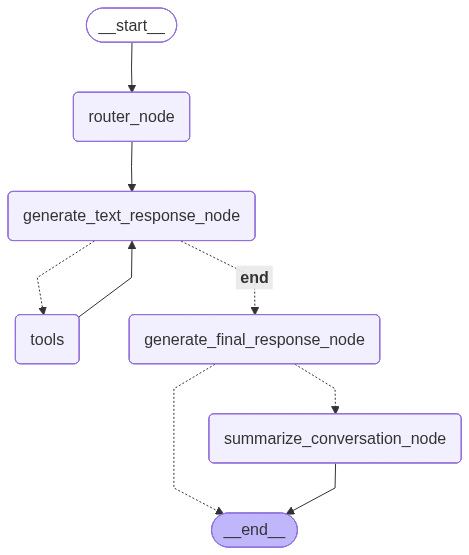

In [ ]:
workflow = StateGraph(KaranState)

workflow.add_node("router_node", router_node)
workflow.add_node("generate_text_response_node", generate_text_response_node)
workflow.add_node("summarize_conversation_node", summarize_conversation_node)
workflow.add_node("tools", tool_node)
workflow.add_node("generate_final_response_node", generate_final_response_node)

workflow.add_edge(START, "router_node")
workflow.add_edge("router_node", "generate_text_response_node")
workflow.add_conditional_edges(
    "generate_text_response_node",
    tools_condition,
    {
        "tools": "tools",
        END: "generate_final_response_node"
    }
)
workflow.add_edge("tools", "generate_text_response_node")
workflow.add_conditional_edges("generate_final_response_node", should_summarize_conversation)

workflow.add_edge("summarize_conversation_node", END)


# Remember to pass the 'short_term_memory' to persist the state!
graph = workflow.compile(checkpointer=short_term_memory)
display(Image(graph.get_graph().draw_mermaid_png()))

Now, let's run some examples.

In [ ]:
config = {"configurable": {"thread_id": "test"}}

Let's begin with a simple interaction.

In [ ]:
results = graph.invoke(
    {"messages": "Hey! What's up buddy?"}, config
)

In [ ]:
results

{'messages': [HumanMessage(content="Hey! What's up buddy?", additional_kwargs={}, response_metadata={}, id='7e8b2c79-5aa0-4dbe-9ce0-ad5174be82f0'),
  AIMessage(content="Hey there! Not much, just hanging out. What about you? By the way, what's your name?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 556, 'total_tokens': 579, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-CNwqgmv96m1bcRwuv2xj1kEod8Mfq', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--12ee8a21-0857-4712-83e3-8fef630144b4-0', usage_metadata={'input_tokens': 556, 'output_tokens': 23, 'total_tokens': 579, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_det

Let's try the same with a voice note. With this example, you can see the router node is working properly!

In [ ]:
results = graph.invoke(
    {"messages": "Can you send me a voice note, so I can hear your voice?"}, config
)

In [ ]:
with open("audio.mp3", "wb") as f:
    f.write(results["audio_buffer"])

from IPython.display import Audio
Audio("audio.mp3")

Finally, let's test the image generation capabilities.

In [ ]:
results = graph.invoke(
    {"messages": "Can you show me a picture of yourself?"}, config
)

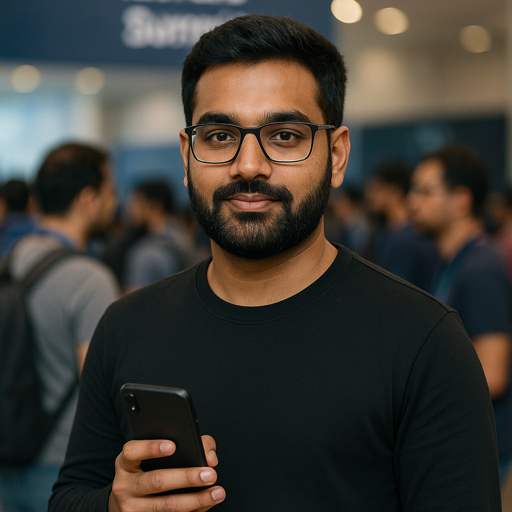

In [ ]:
PIL.Image.open(results["image_path"]).resize((512, 512))

Works!! Time to bring Karan to Telegram 😎

# Telegram integration

We'll begin by implementing a function to invoke our graph. You'll see it's a bit different than before ... we're using `tenacity` for exponential backoff.

In [ ]:
# Retry config: 3 tries, exponential backoff, log on failure
@retry(
    stop=stop_after_attempt(3),
    wait=wait_exponential(multiplier=1, min=2, max=10),
    retry=retry_if_exception_type(Exception),
    reraise=True
)
def safe_graph_invoke(payload, config=None):
  config = {"configurable": {"thread_id": "miguel"}} # Don't forget to pass the thread_id!
  return graph.invoke(payload, config)

Now, we need three functions to handle the text input, the audio input and the image input. Let's go!

## Text Messages

The simplest. Just takes the user's text message and sends it to the graph. Then, takes the response and sends it back.

In [ ]:
async def handle_text(update: Update, context: ContextTypes.DEFAULT_TYPE):
    user_message = update.message.text

    response = response = safe_graph_invoke(
        {"messages": user_message}, config)

    await send_response(update, context, response)

## Voice messages

Uses Whisper to generate the transcription of the user's voice message. Then, it sends the transcription to the graph.

In [ ]:
async def handle_voice(update: Update, context: ContextTypes.DEFAULT_TYPE):
    voice = update.message.voice
    file = await context.bot.get_file(voice.file_id)
    file_path = "voice.ogg"
    await file.download_to_drive(file_path)

    with open(file_path, "rb") as audio_file:
        transcription = openai_client.audio.transcriptions.create(
            file=audio_file,
            model="whisper-1",
        )
    os.remove(file_path)

    response = safe_graph_invoke(
        {"messages": transcription.text}, config)

    await send_response(update, context, response)

## Image Messages

Generates a caption from the user's image. Then, it sends this caption (with the image caption, if provided) to the graph.

In [ ]:
async def handle_photo(update: Update, context: ContextTypes.DEFAULT_TYPE):
    photo = update.message.photo[-1]
    file = await context.bot.get_file(photo.file_id)
    file_path = "image.jpg"
    await file.download_to_drive(file_path)

    with open(file_path, "rb") as img_file:
        base64_image = base64.b64encode(img_file.read()).decode("utf-8")

    os.remove(file_path)

    # Step 1: Get vision response
    vision_response = openai_client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "Describe what you see in the picture"},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}",
                        },
                    },
                ],
            }
        ],
    )

    description = vision_response.choices[0].message.content.strip()

    # Step 2: Extract user caption if provided
    user_caption = update.message.caption or ""

    # Step 3: Compose full message for graph
    combined_message = f"{user_caption} [IMAGE_ANALYSIS] {description}".strip()

    # Step 4: Invoke graph
    response = safe_graph_invoke(
        {"messages": combined_message}, config)

    # Step 5: Add description as caption for the outgoing image response
    if "messages" in response and isinstance(response["messages"][-1], dict):
        response["messages"][-1]["caption"] = description

    await send_response(update, context, response)

## Processing multimodal responses

Even if we handle all the different incoming message types, what about the outgoing ones — like generated audio or images?

The `send_response` function is responsible for that. It takes the final graph state, pulls out whatever response was generated (text, image, audio, etc.), and sends it back to the user via Telegram.

In [ ]:
async def send_response(update: Update, context: ContextTypes.DEFAULT_TYPE, response: dict):
    last_message = response["messages"][-1]
    content = last_message.content
    response_type = response["response_type"]

    if response_type == "text":
        await update.message.reply_text(content)

    elif response_type == "audio":
        audio_bytes = response.get("audio_buffer")
        if audio_bytes:
            await update.message.reply_voice(voice=audio_bytes)

    elif response_type == "image":
        img_path = response.get("image_path")
        if img_path and os.path.exists(img_path):
            with open(img_path, "rb") as img_file:
                await update.message.reply_photo(photo=img_file)

    else:
        await update.message.reply_text("Sorry, I can't talk right now buddy! 😔")

Phew, that was a long run ... but my dear friend, it's time to start our Telegram Bot!

In [ ]:
TELEGRAM_BOT_TOKEN = os.getenv("TELEGRAM_BOT_TOKEN")

def start_bot():
    app = Application.builder().token(TELEGRAM_BOT_TOKEN).build()

    app.add_handler(MessageHandler(filters.VOICE, handle_voice))
    app.add_handler(MessageHandler(filters.PHOTO, handle_photo))
    app.add_handler(MessageHandler(filters.TEXT & ~filters.COMMAND, handle_text))

    print("Karan is waking up ...")
    app.run_polling()

In [ ]:
nest_asyncio.apply()

await start_bot()

Karan is waking up ...
